<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_5_DiscoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title IMPORTS 
#@markdown run to import modules
import argparse
import os
import numpy as np
import math
import itertools
import scipy
import sys
import time
import datetime

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output

In [101]:
#@title HYPERPARAMETERS 
dataset_name = "monet2photo" #@param ["monet2photo", "apple2orange", "horse2zebra", "vangogh2photo","summer2winter_yosemite"]
class Hyperparameters(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

datasets = { "monet2photo" : { "url" : 'https://www.dropbox.com/s/wju2w0dmhgyto3g/monet2photo.zip?dl=1',
                          "train_mode" : "train",
                          "test_mode" : "test"},
            "apple2orange" : { "url" : "https://www.dropbox.com/s/2qw5l7sr896gzyk/apple2orange.zip?dl=1",
                            "train_mode" : "train",
                            "test_mode" : "test"},
            "horse2zebra" : { "url" : "https://www.dropbox.com/s/mik8t7e92bceppx/horse2zebra.zip?dl=1",
                      "train_mode" : "train",
                      "test_mode" : "test"},
            "vangogh2photo" : { "url" : "https://www.dropbox.com/s/49hwp1plw95ap3n/vangogh2photo.zip?dl=1",
                      "train_mode" : "train",
                      "test_mode" : "test"},
            "summer2winter_yosemite" : { "url" : "https://www.dropbox.com/s/74774vv30vux7rb/summer2winter_yosemite.zip?dl=1",
                      "train_mode" : "train",
                      "test_mode" : "test"}
            
            }

hp = Hyperparameters(
    epoch=0,
    n_epochs=600,
    batch_size=8,    
    dataset_name=dataset_name,
    dataset_url=datasets[dataset_name]["url"],
    dataset_train_mode=datasets[dataset_name]["train_mode"],
    dataset_test_mode=datasets[dataset_name]["test_mode"],    
    lr=.0002,
    b1=.5,
    b2=0.999,
    n_cpu=8,
    img_size=128,
    channels=3,    
    sample_interval=100
    )

img_root_folder = 'images'
os.makedirs(img_root_folder, exist_ok=True)
image_folder = img_root_folder + "/%s" % hp.dataset_name 
print(f"Image data folders constructed {image_folder}")
os.makedirs(image_folder, exist_ok=True)

Image data folders constructed images/monet2photo


In [75]:
#@title DOWNLOAD DATASET
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
zipurl = hp.dataset_url
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:        
        zfile.extractall(img_root_folder)
        print(f"Downloaded & Extracted {zipurl}")

Downloaded & Extracted https://www.dropbox.com/s/49hwp1plw95ap3n/vangogh2photo.zip?dl=1


In [76]:
#@title IMAGE DOWNLOAD HELPERS AND FORATTERS

import glob
import random
from torch.utils.data import Dataset
from PIL import Image

def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image


class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, "%s/A" % mode) + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, "%s/B" % mode) + "/*.*"))

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [77]:
#@title IMAGE VISUALIZER HELPERS
def imshow(img,size=10):
  img = img / 2 + 0.5     
  npimg = img.numpy()
  plt.figure(figsize=(size, size))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def to_img(x):    
    x = x.view(x.size(0)*2, hp.channels, hp.img_size, hp.img_size)
    return x

import matplotlib.image as mpimg
def visualise_output(path, x, y):
    img = mpimg.imread(path)
    plt.figure(figsize=(x,y))
    plt.imshow(img)  
    plt.show()

In [98]:
#@title CONFIGURE DATALOADERS
transforms_ = [
    transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

dataloader = DataLoader(
    ImageDataset(image_folder, mode=hp.dataset_train_mode, transforms_=transforms_),
    batch_size=hp.batch_size,
    shuffle=True,
    num_workers=1,
)
val_dataloader = DataLoader(
    ImageDataset(image_folder, mode=hp.dataset_test_mode, transforms_=transforms_),
    batch_size=16,
    shuffle=True,
    num_workers=1,
)

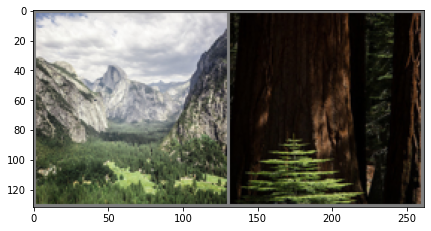

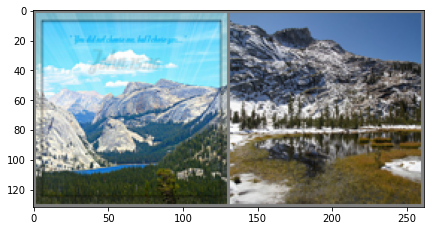

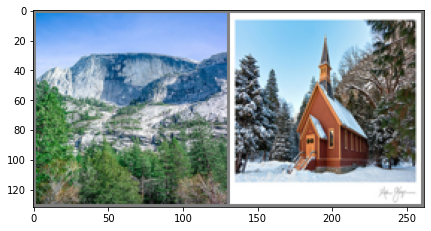

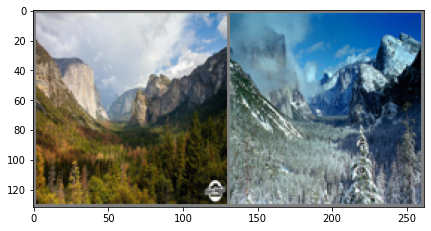

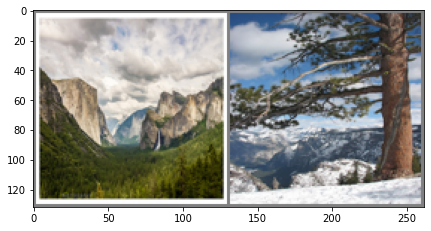

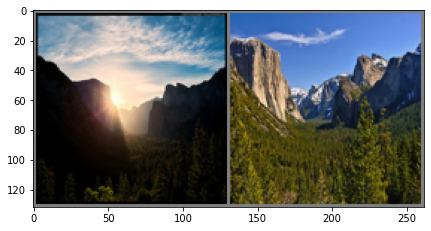

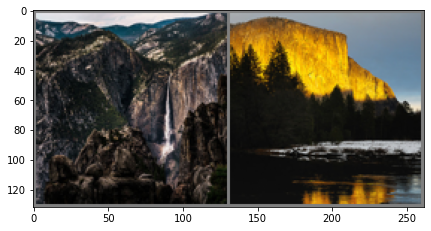

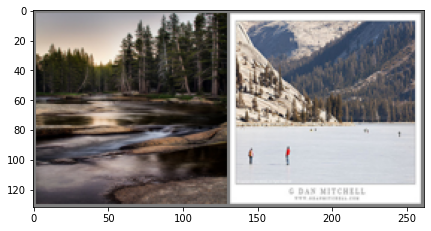

In [96]:
#@title VISUALING SAMPLE DATA { run: "auto" }
pic_size = 7 #@param {type:"integer"} {type:"slider", min:1, max:30, step:1}

dataiter = iter(dataloader)
images = dataiter.next()

for i in range(len(images["A"])):
  imshow(make_grid([images["A"][i],images["B"][i]]), size=pic_size)

In [80]:
#@title GENERATOR & DISCRIMINATOR
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

##############################
#           U-NET
##############################
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [nn.ConvTranspose2d(in_size, out_size, 4, 2, 1), nn.InstanceNorm2d(out_size), nn.ReLU(inplace=True)]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

class GeneratorUNet(nn.Module):
    def __init__(self, input_shape):
        super(GeneratorUNet, self).__init__()
        channels, _, _ = input_shape
        self.down1 = UNetDown(channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256, dropout=0.5)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5, normalize=False)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 256, dropout=0.5)
        self.up4 = UNetUp(512, 128)
        self.up5 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2), nn.ZeroPad2d((1, 0, 1, 0)), nn.Conv2d(128, channels, 4, padding=1), nn.Tanh()
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        u1 = self.up1(d6, d5)
        u2 = self.up2(u1, d4)
        u3 = self.up3(u2, d3)
        u4 = self.up4(u3, d2)
        u5 = self.up5(u4, d1)

        return self.final(u5)


##############################
#        Discriminator
##############################
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape
        # Calculate output of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 3, width // 2 ** 3)

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(256, 1, 4, padding=1)
        )

    def forward(self, img):
        # Concatenate image and condition image by channels to produce input
        return self.model(img)

In [81]:
#@title SETUP, LOSS and INITIALIZE MODELS

cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")

adversarial_loss = torch.nn.MSELoss()
cycle_loss = torch.nn.L1Loss()
pixelwise_loss = torch.nn.L1Loss()

input_shape = (hp.channels, hp.img_size, hp.img_size)

# Initialize generator and discriminator
G_AB = GeneratorUNet(input_shape)
G_BA = GeneratorUNet(input_shape)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    adversarial_loss.cuda()
    cycle_loss.cuda()
    pixelwise_loss.cuda()

# Initialize weights
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)


Using CUDA


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (9): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [82]:
#@title SAMPLING IMAGES
def sample_images(batches_done):
    """Saves a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    real_A = Variable(imgs["A"].type(FloatTensor))
    fake_B = G_AB(real_A)
    AB = torch.cat((real_A.data, fake_B.data), -2)
    real_B = Variable(imgs["B"].type(FloatTensor))
    fake_A = G_BA(real_B)
    BA = torch.cat((real_B.data, fake_A.data), -2)
    img_sample = torch.cat((AB, BA), 0)
    path = "images/%s/%s.png" % (hp.dataset_name, batches_done)
    save_image(img_sample, path, nrow=8, normalize=True)
    return path
    

In [83]:
#@title OPTIMIZERS
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=hp.lr, betas=(hp.b1, hp.b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

# Input tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [ ]:
#@title TRAINING
prev_time = time.time()
for epoch in range(hp.n_epochs):
    for i, batch in enumerate(dataloader):
        # Model inputs
        real_A = Variable(batch["A"].type(Tensor))
        real_B = Variable(batch["B"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------
        G_AB.train()
        G_BA.train()

        optimizer_G.zero_grad()

        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = adversarial_loss(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = adversarial_loss(D_A(fake_A), valid)

        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        # Pixelwise translation loss
        loss_pixelwise = (pixelwise_loss(fake_A, real_A) + pixelwise_loss(fake_B, real_B)) / 2

        # Cycle loss
        loss_cycle_A = cycle_loss(G_BA(fake_B), real_A)
        loss_cycle_B = cycle_loss(G_AB(fake_A), real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # Total loss
        loss_G = loss_GAN + loss_cycle + loss_pixelwise

        loss_G.backward()
        optimizer_G.step()

        # -----------------------
        #  Train Discriminator A
        # -----------------------

        optimizer_D_A.zero_grad()

        # Real loss
        loss_real = adversarial_loss(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        loss_fake = adversarial_loss(D_A(fake_A.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2

        loss_D_A.backward()
        optimizer_D_A.step()

        # -----------------------
        #  Train Discriminator B
        # -----------------------

        optimizer_D_B.zero_grad()
        # Real loss
        loss_real = adversarial_loss(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        loss_fake = adversarial_loss(D_B(fake_B.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2

        loss_D_B.backward()
        optimizer_D_B.step()

        loss_D = 0.5 * (loss_D_A + loss_D_B)

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = hp.n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, pixel: %f, cycle: %f] ETA: %s"
            % (
                epoch,
                hp.n_epochs,
                i,
                len(dataloader),
                loss_D.item(),
                loss_G.item(),
                loss_GAN.item(),
                loss_pixelwise.item(),
                loss_cycle.item(),
                time_left,
            )
        )

        # If at sample interval save image
        if batches_done % hp.sample_interval == 0:
            clear_output()            
            visualise_output(sample_images(batches_done), 40,40)    